In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import numpy as np
from scipy import ndimage as ndi

from skimage import (
    exposure, io, morphology, color, feature, filters, util, segmentation
)
import math
#import napari
#from napari.utils import nbscreenshot
from scipy import signal
from skimage.filters import threshold_multiotsu
from skimage.filters import try_all_threshold, gaussian
from skimage.morphology import disk
from skimage.filters import threshold_li
from skimage import measure
import pandas as pd
import os
#import PyDIP as dip
import math
import re
from glob import glob
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from skimage.segmentation import random_walker, clear_border
from scipy import ndimage
from skimage.measure import label, regionprops, regionprops_table
from skimage.exposure import histogram

In [2]:
def slice(im3d):
    stack_size = im3d.shape[0]
    hist=[]
    for i in range(stack_size):
        hist.append(im3d[i,:,:].mean())
    plt.plot(range(stack_size),hist, '.-')
    #if len(signal.argrelextrema(np.array(hist), np.greater)) <= 2:
    grad1 = np.gradient(hist)
    peaks, ups = signal.find_peaks(grad1,max(grad1)*0.1)
    peaks2, ups2 = signal.find_peaks(hist,max(hist)*0.1)
    #plt.vlines([maximums],0,max(hist), colors='r')
    plt.vlines([peaks2],0,max(hist), colors='b')
    chosen=[]
    for i in range(stack_size):
        if hist[i] >= (ups['peak_heights'][0]+2*ups2['peak_heights'][0])/3:
            plt.vlines(i,0,max(hist), colors='y')
            chosen.append(i)
    return chosen

In [3]:
def slice_manual(im3d,start,stop):
    stack_size = im3d.shape[0]
    hist=[]
    for i in range(stack_size):
        hist.append(im3d[i,:,:].mean())
    plt.plot(range(stack_size),hist, '.-')
    #if len(signal.argrelextrema(np.array(hist), np.greater)) <= 2:
    grad1 = np.gradient(hist)
    peaks, ups = signal.find_peaks(grad1,max(grad1)*0.1)
    peaks2, ups2 = signal.find_peaks(hist,max(hist)*0.1)
    #plt.vlines([maximums],0,max(hist), colors='r')
    plt.vlines([peaks2],0,max(hist), colors='b')
    chosen = range(start,stop)
    for i in chosen:
        plt.vlines(i,0,max(hist), colors='y')
    return chosen

In [4]:
def display(im3d, cmap="gray", step=1, chosen = None):
    if chosen is None: 
        chosen = []
    stack_size = im3d.shape[0]
    cols = 5
    rows = math.ceil((stack_size/cols))
    
    h , axes = plt.subplots(nrows=rows, ncols=cols, figsize=(3*cols, 3*rows))
    #print(h)
    #p1 = get(h,'Position')
    #annotation('rectangle',p1,'FaceAlpha',.2,'FaceColor','red','EdgeColor','red') 
    vmin = im3d.min()
    vmax = im3d.max()
    enum = 0
    for ax, image in zip(axes.flatten(), im3d[::step]):
        ax.imshow(image, cmap=cmap, vmin=vmin, vmax=vmax)
        if enum in chosen:
            for axis in ['top','bottom','left','right']:
                #ax.spines[axis].set_linewidth(0.5)
                ax.spines[axis].set_color("red")
                ax.spines[axis].set_linewidth(5)
        ax.set_xticks([])
        ax.set_yticks([])
        enum += 1
    #plt.savefig('foo.png')
    

In [5]:
def display_slice(im, cmap="gray", step=1, chosen = None, savefig = False):
    h , axes = plt.subplots(1,1)
    vmin = im.min()
    vmax = im.max()
    enum = 0
    axes.imshow(im, cmap=cmap, vmin=vmin, vmax=vmax)

In [6]:
ResultsDir = "/groups/gerlich/labinfo/2023_Batty_et_al/emboj_revised_submission/fig_by_fig_emboj_revised_manuscript/ev_figures/fig_ev4/panel_d/output/"

In [7]:
#Define function to threshold a field of cells using MultiOtsu thresholding from skimage
#apply watershedding and then extract features >>> final output is a dataframe

#To do >>> extract metadata automatically using TIFFFILE

In [8]:
def image_stdev(region, intensities):
    # note the ddof arg to get the sample var if you so desire!
    return np.std(intensities[region], ddof=1)

In [9]:
#background subtraction - mean fluorescence in background of three cells drawn, divided by three to subtract from the mean fluorescence of each channel

#2045 minus - Hoechst, 0.056, 0.056, 0.089, 0.128, 0.140, 0.143 
#2045 minus - NIPBL, 5.886, 5.745, 6.068, 7.525, 7.310, 7.572 >>> 6.68






In [10]:
pixel_size = (14.1681)
#this is the number of pixels per micron, change the pixel size according to your specific image
scaling_factor = pixel_size**2




def threshold_field(images):
    
    #Set up variables as empty dataframes
    all_hoechst = pd.DataFrame()
    all_nipbl = pd.DataFrame()

    #read in files
    for image in images:
        data = io.imread(image)
        #select channels, wapl = channel3, Scc1 = channel2, Hoechst = channel 1 in this image
        hoechst = data[0,:,:]
        nipbl = data[1,:,:]
       
        
        sigma = 1.0

        # apply Gaussian blur, creating a new image
        blurred = filters.gaussian(
        hoechst, sigma=(sigma, sigma), truncate=3.5, multichannel=True)
        #display_slice(blurred)


        #threshold the hoechst_channel using multiotsu thresholding
        thresh = threshold_li(blurred)
        #mask = hoechst > thresh
        
        binary_mask = morphology.binary_closing(blurred > thresh, disk(6)) 
        
        #binary_mask = ndimage.binary_fill_holes(blurred).astype(int)
        
        cleared = clear_border(binary_mask)
        remove_debris = morphology.remove_small_objects(cleared, 20000)
        

        #optimise thresholding parameters for this dataset

        #igher_threshold = 60
        #ilt = hoechst > higher_threshold

        #moother_filt = filters.rank.mean(util.img_as_ubyte(remove_debris),
                                      #orphology.disk(4))

        #inal_thresh = smoother_filt > 60

        #apply watershedding to distinguish cells which are thresholded as a single cell when in reality there are two
        distance = ndi.distance_transform_edt(remove_debris)

        local_max_coords = feature.peak_local_max(distance, min_distance=50)
        local_max_mask = np.zeros(distance.shape, dtype=bool)
        local_max_mask[tuple(local_max_coords.T)] = True
        markers = measure.label(local_max_mask)

        segmented_cells = segmentation.watershed(-distance, markers, mask=remove_debris)
        
        remove_small_masks = morphology.remove_small_objects(segmented_cells, 15000)
        
        segmented_cells = remove_small_masks

        #this is the number of pixels per micron, change the pixel size according to your specific image
        #Generate labels, each thresholded object becomes a label
        pixel_size = (14.1681)
        scaling_factor = pixel_size**2

        #Generate labels, each thresholded object becomes a label
        labels = measure.label(segmented_cells)
        properties = measure.regionprops(labels)

        #choose which features to extract and extract features for the first channel. Calculate nuclear area

        properties_hoechst = ["area", "mean_intensity"]
        output_hoechst = pd.DataFrame(regionprops_table(labels, hoechst, 
             properties=properties_hoechst))
        #rename columns
        output_hoechst = output_hoechst.rename(columns={"area":"area_pixels"})
        output_hoechst = output_hoechst.rename(columns={"mean_intensity":"mean_hoechst"})

        #get nuclear area in microns instead of pixels and then calculate total intensity per nucleus
        output_hoechst["nuclear_area_microns"] = output_hoechst["area_pixels"]/scaling_factor
        #calculate total intensity 
        output_hoechst["total_hoechst"] = output_hoechst["nuclear_area_microns"] * output_hoechst["mean_hoechst"]

        #extract info for second channel, area is the same as for the first channel
        properties_nipbl = ["mean_intensity"]
        #extra_properties = ["image_stdev"]
        output_nipbl = pd.DataFrame(regionprops_table(labels, nipbl, 
             properties=properties_nipbl))
        output_nipbl = output_nipbl.rename(columns={"mean_intensity":"mean_nipbl"})
        #output_scc1 = output_scc1.rename(columns={"image_stdev":"std_scc1"})
        output_nipbl["total_nuclear_nipbl"] = output_hoechst["nuclear_area_microns"] * output_nipbl["mean_nipbl"]

        props_hoechst = pd.DataFrame(regionprops_table(labels, hoechst, extra_properties=[image_stdev]))
        
        output_hoechst["std_hoechst"] = props_hoechst["image_stdev"]       
        
        props_nipbl = pd.DataFrame(regionprops_table(labels, nipbl, extra_properties=[image_stdev]))
        
        output_nipbl["std_nipbl"] = props_nipbl["image_stdev"]
        
        #for i in range(len(properties)):
            #print(properties[i].area)
        
        #Display thresholding to check if it is appropriate
        #display_slice(hoechst)
        #display_slice(final_thresh)
        #display_slice(segmented_cells)
        image_name = image
        print(image_name)
        fig, ax = plt.subplots(ncols=4, figsize=(25, 5))
        ax[0].imshow(hoechst, cmap='gray')
        ax[0].set_title('Original Image')
        ax[0].axis('off')
        ax[1].imshow(blurred, cmap='gray')
        ax[1].set_title('Blurred Image')
        ax[1].axis('off')
        ax[2].imshow(remove_debris, cmap='gray')
        ax[2].set_title('Threshold binary mask')
        ax[2].axis('off')
        ax[3].imshow(color.label2rgb(segmented_cells, bg_label=0))
        ax[3].set_title('Segmented nuclei after watershedding')
        ax[3].axis('off')
        plt.show()

        all_hoechst = all_hoechst.append(output_hoechst)
        all_nipbl = all_nipbl.append(output_nipbl)
       
        #print(output_hoechst)
        #print(output_scc1)
        #print(all_hoechst)
        #print(all_scc1)
        all_data = pd.concat([all_hoechst, all_nipbl], axis=1)
        all_data["image_name"] = image_name
        #print(all_data)
    
    #reorder columns for final output
    final_df = all_data[["image_name", "nuclear_area_microns", "mean_hoechst", "mean_nipbl", "total_hoechst", "total_nuclear_nipbl", "std_hoechst", "std_nipbl"]]
    #exclude mitotic cells
        final_df = final_df.loc[(final_df.nuclear_area_microns > 100)]
    
    final_df["coeff_variance_hoechst"] = final_df["std_hoechst"]/final_df["mean_hoechst"]
    final_df["coeff_variance_nipbl"] = final_df["std_nipbl"]/final_df["mean_nipbl"]
    final_df["condition"] = "2045_plus_auxin"

    #output final dataframe to the results directory
    #final_df.to_csv(os.path.join(ResultsDir + "test.csv"), index = False)
    final_df.to_csv(os.path.join(ResultsDir + "2045_plus_auxin_fields_rep2_3.csv"), index = False)
    return final_df


/tmp/ipykernel_27742/2352927789.py:32: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0.Please use `channel_axis` instead.
  blurred = filters.gaussian(
/opt/conda/lib/python3.9/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/conda/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


well1_2045_plus_aux_po1-16 #04.tif


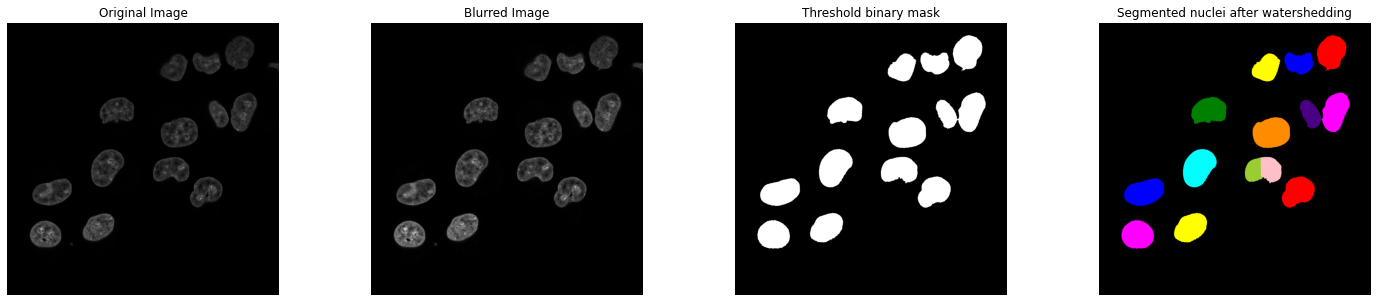

well1_2045_plus_aux_po1-16 #03.tif


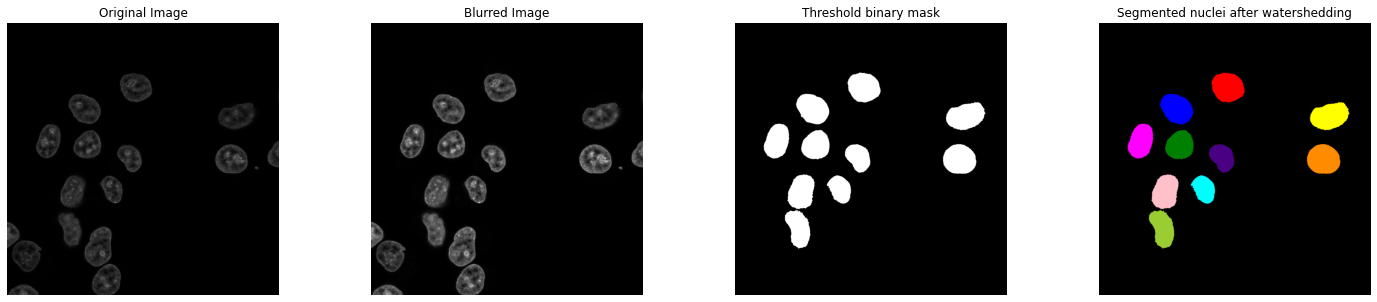

well1_2045_plus_aux_po1-16 #02.tif


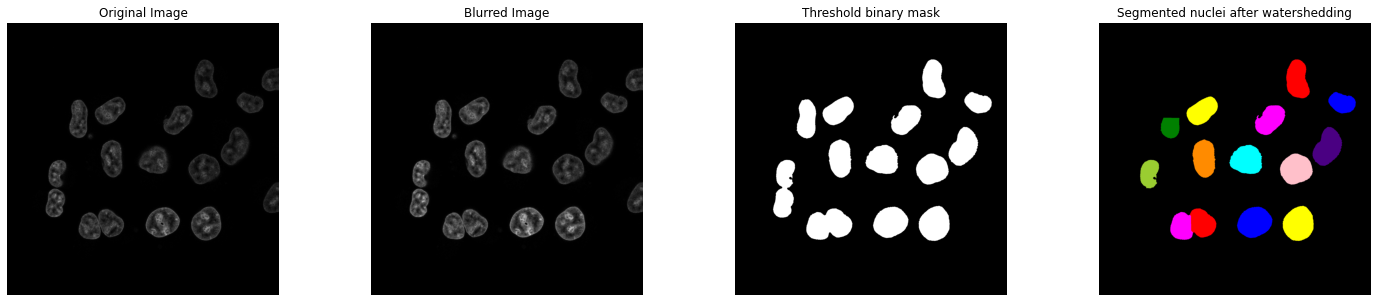

well1_2045_plus_aux_po1-16 #05.tif


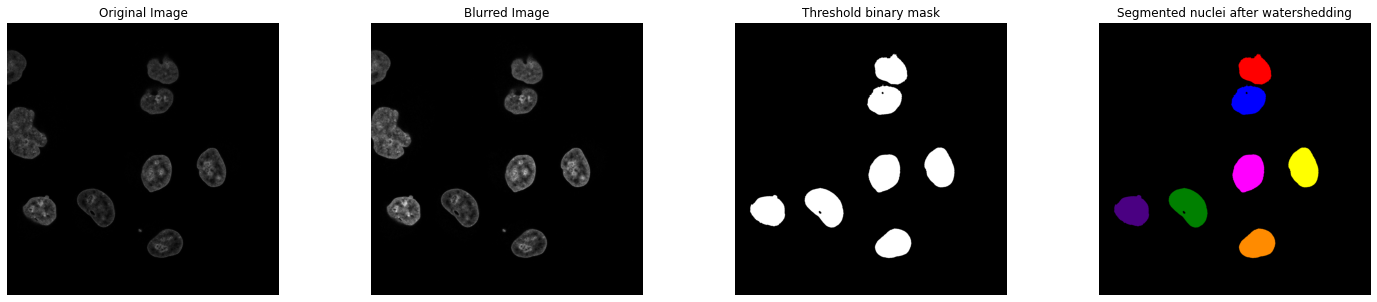

well1_2045_plus_aux_po1-16 #06.tif


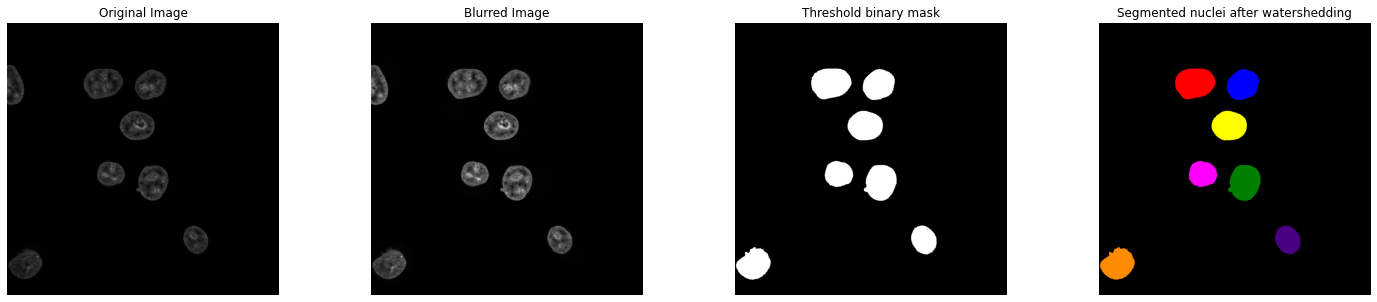

well1_2045_plus_aux_po1-16 #07.tif


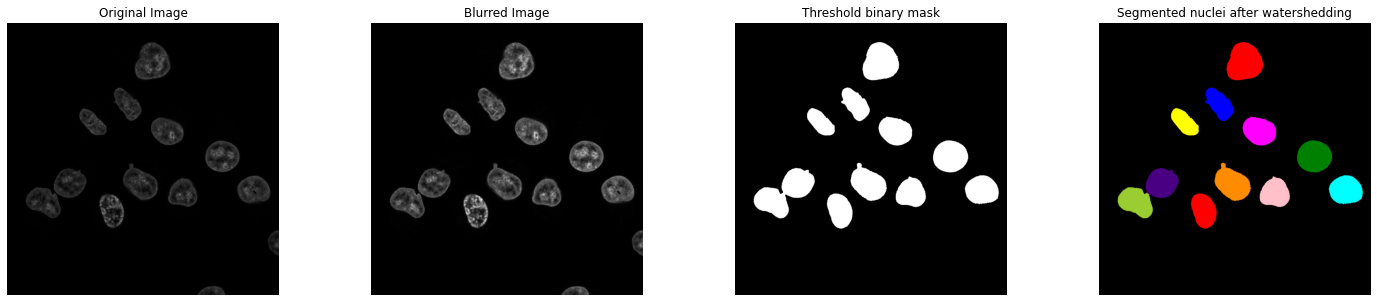

well1_2045_plus_aux_po1-16 #08.tif


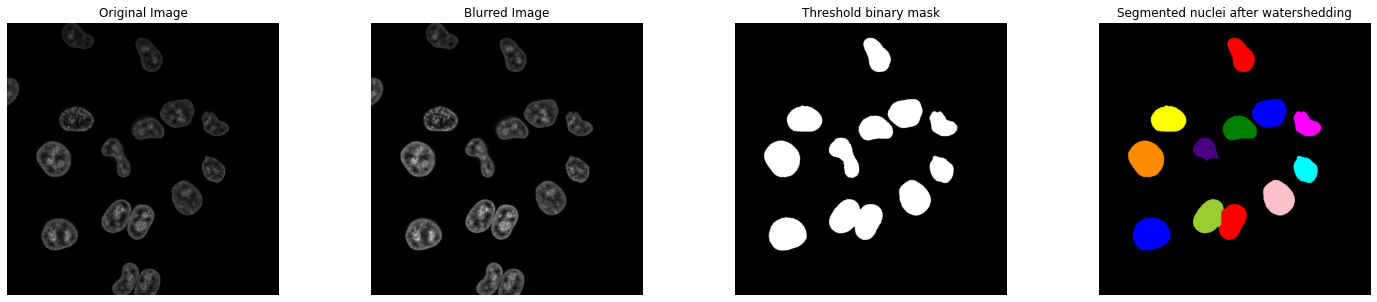

well1_2045_plus_aux_po1-16 #09.tif


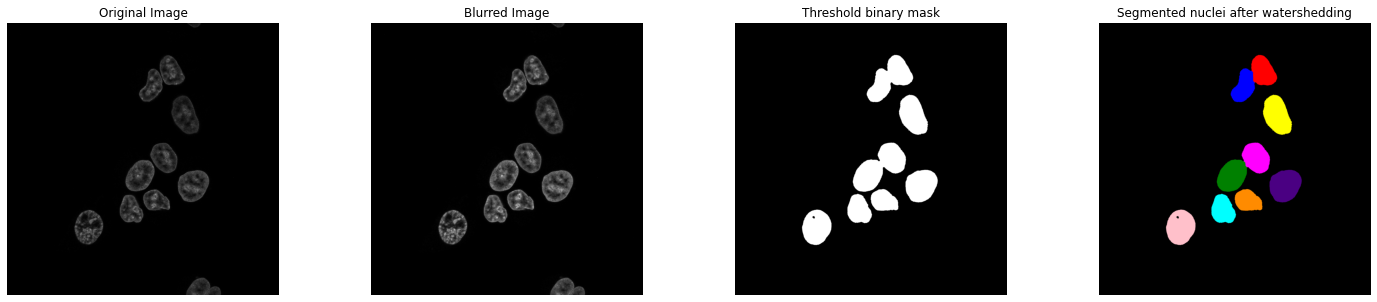

well1_2045_plus_aux_po1-16 #10.tif


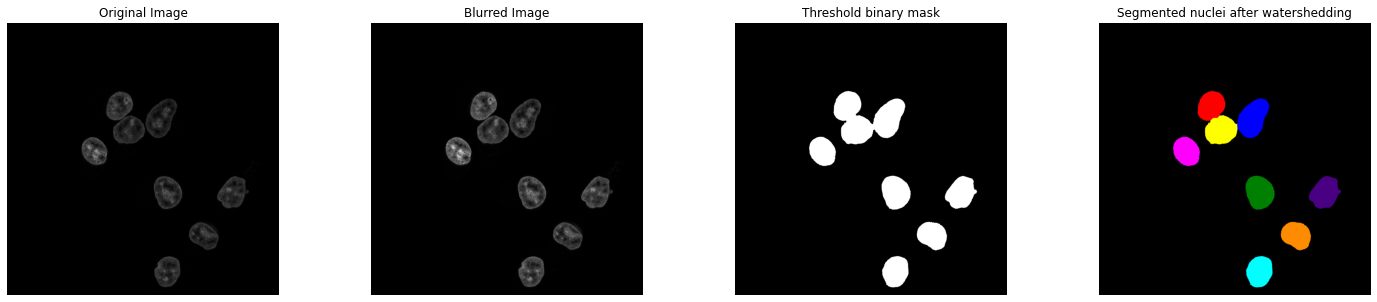

well1_2045_plus_aux_po1-16 #12.tif


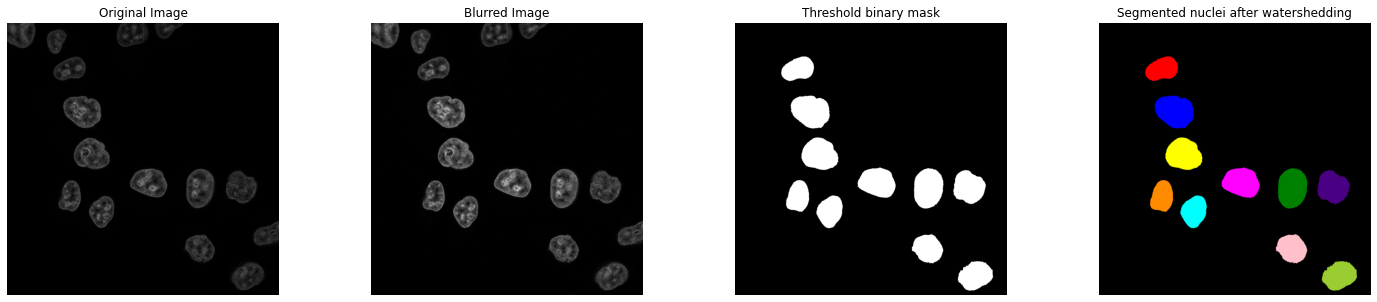

well1_2045_plus_aux_po1-16 #11.tif


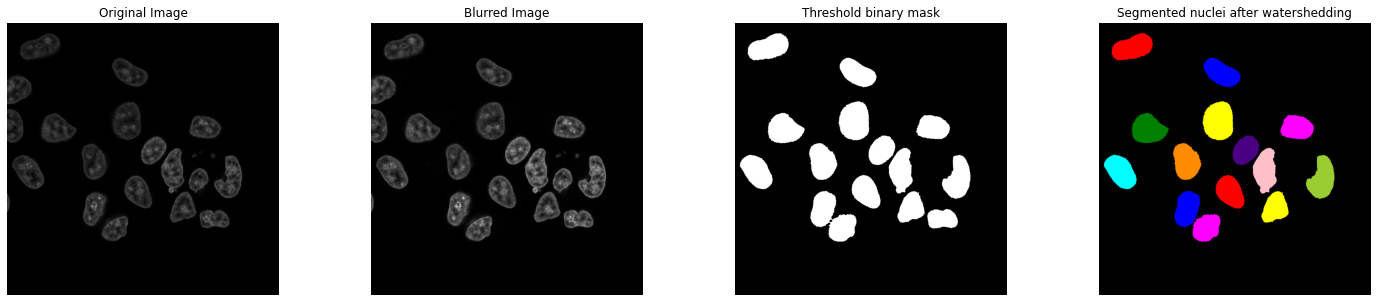

well1_2045_plus_aux_po1-16 #13.tif


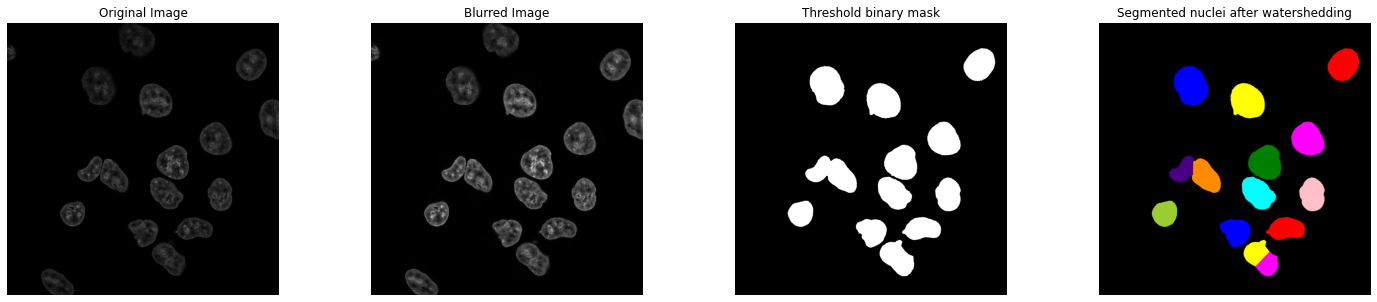

well1_2045_plus_aux_po1-16 #14.tif


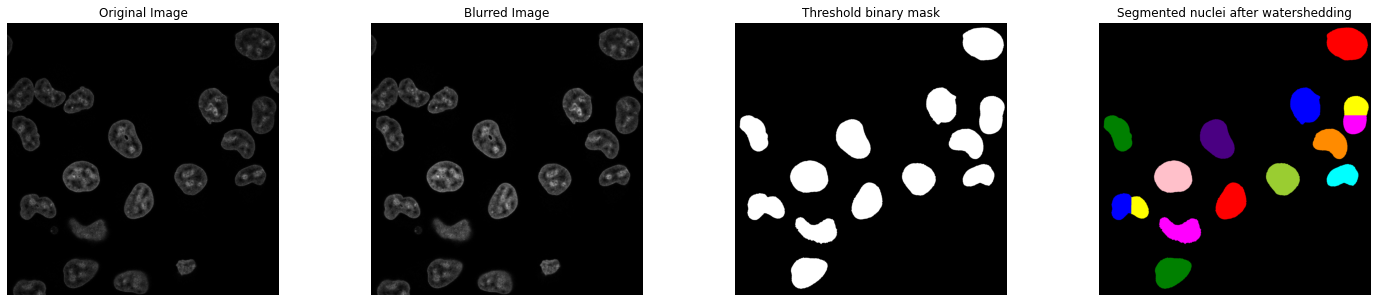

well1_2045_plus_aux_po1-16 #15.tif


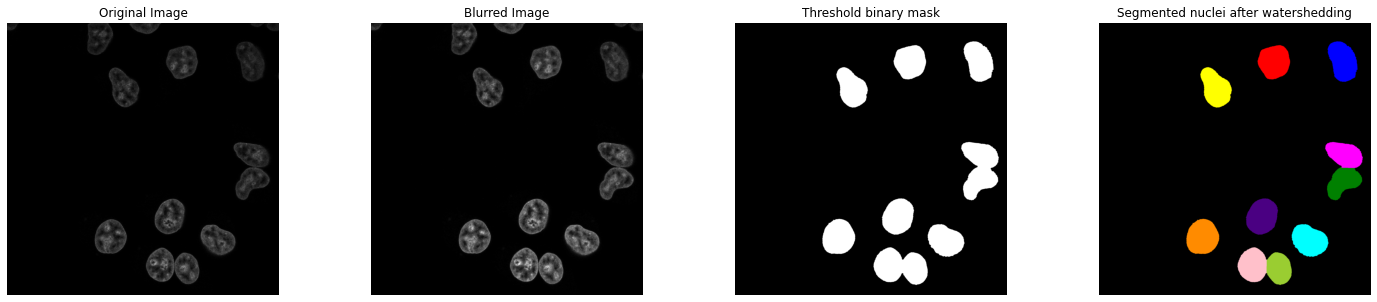

well1_2045_plus_aux_po1-16 #16.tif


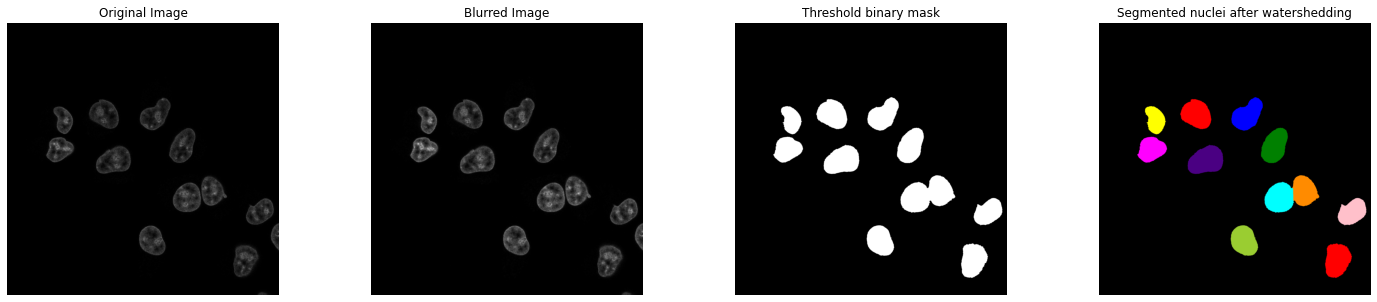

well1_2045_plus_aux_pos17-28 #01.tif


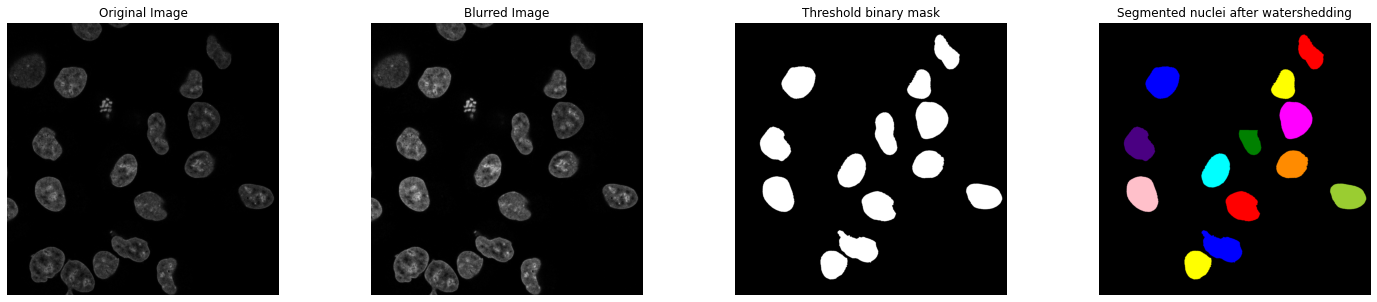

well1_2045_plus_aux_pos17-28 #02.tif


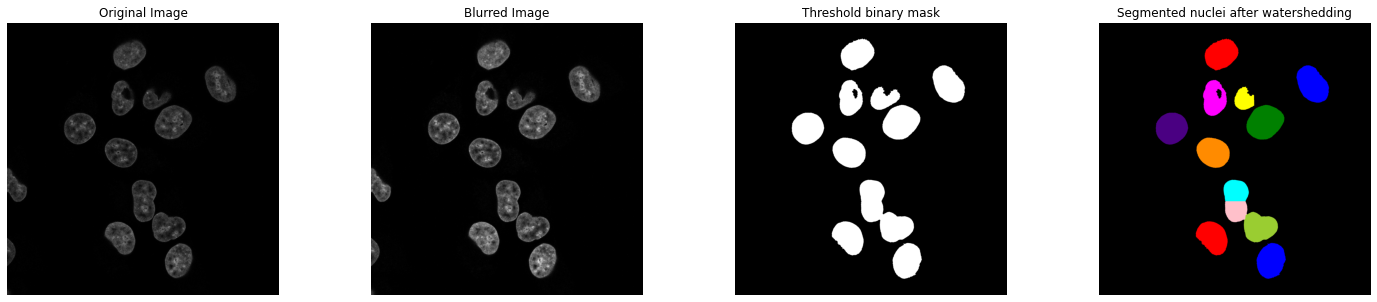

well1_2045_plus_aux_pos17-28 #03.tif


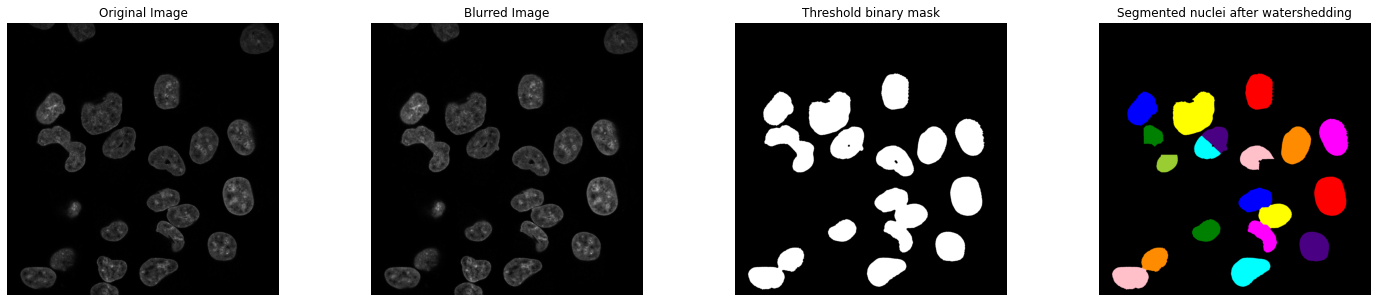

well1_2045_plus_aux_pos17-28 #04.tif


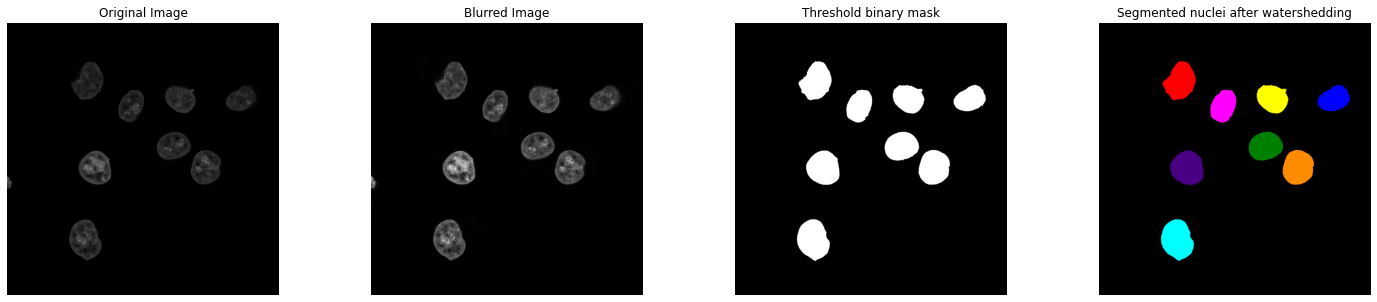

well1_2045_plus_aux_pos17-28 #05.tif


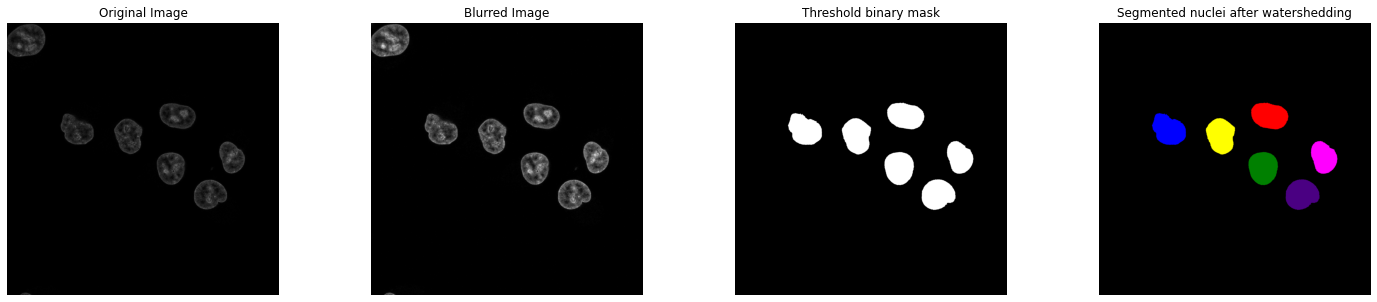

well1_2045_plus_aux_pos17-28 #06.tif


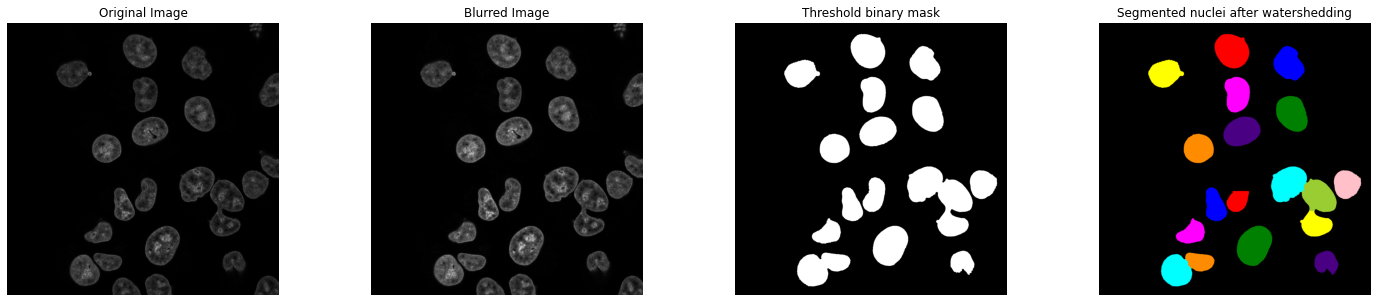

well1_2045_plus_aux_pos17-28 #07.tif


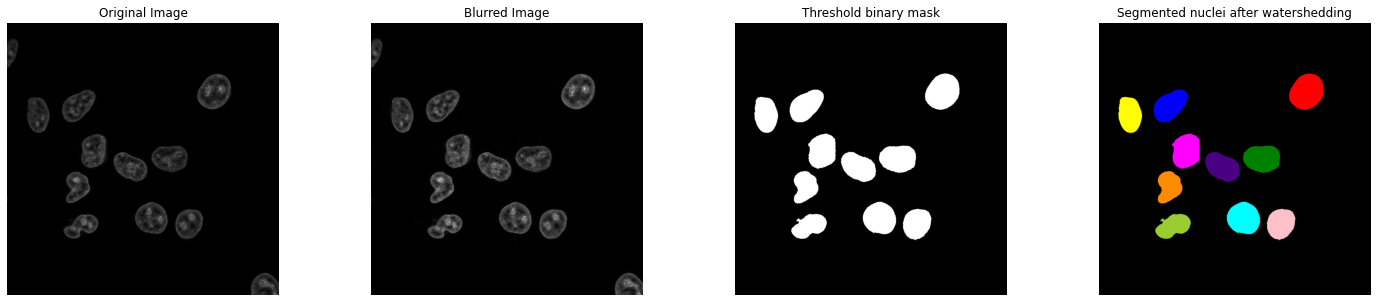

well1_2045_plus_aux_pos17-28 #08.tif


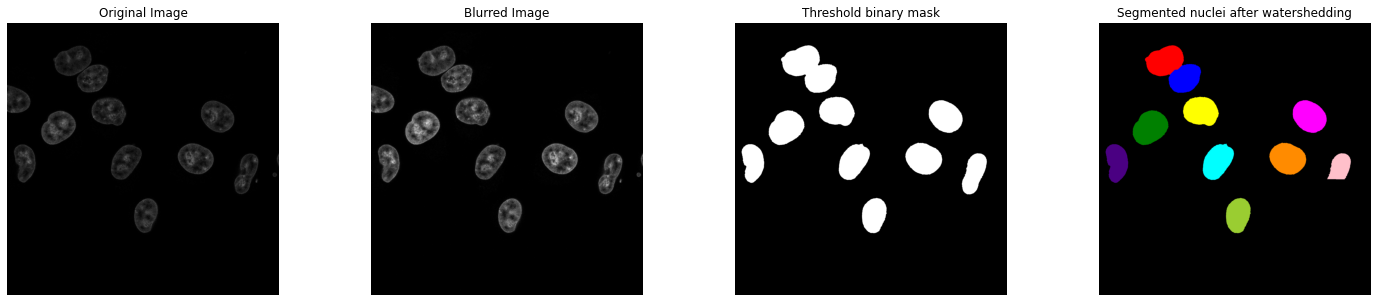

well1_2045_plus_aux_pos17-28 #09.tif


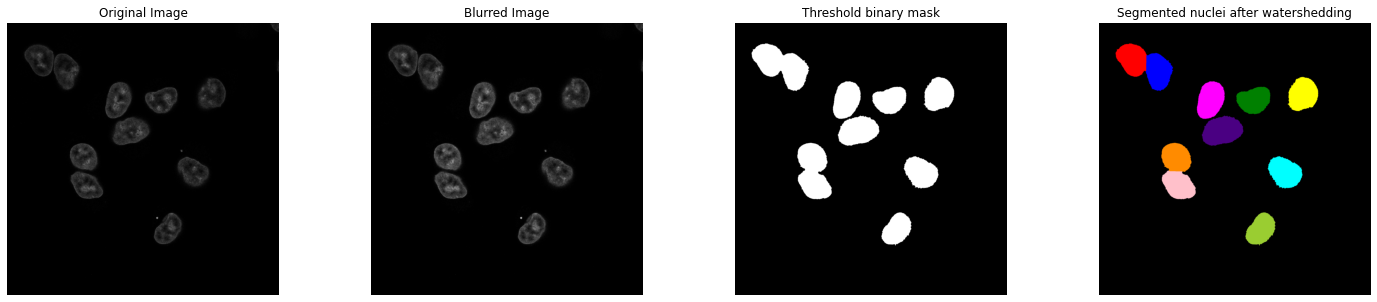

well1_2045_plus_aux_pos17-28 #10.tif


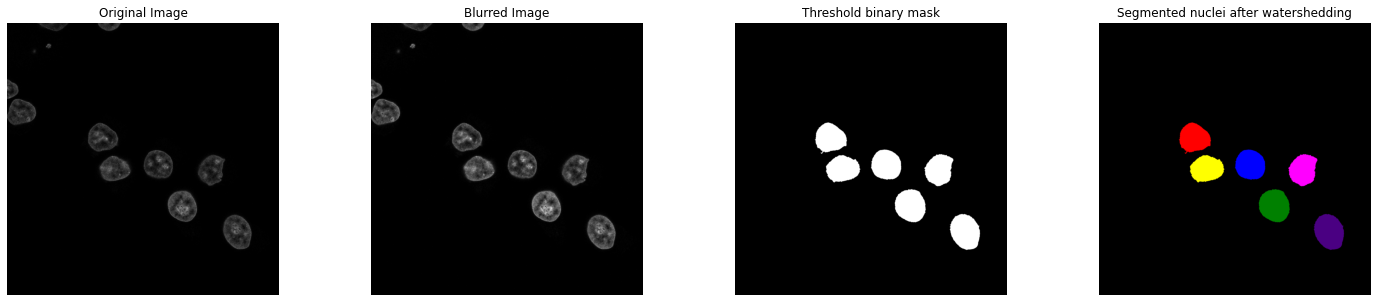

well1_2045_plus_aux_pos17-28 #11.tif


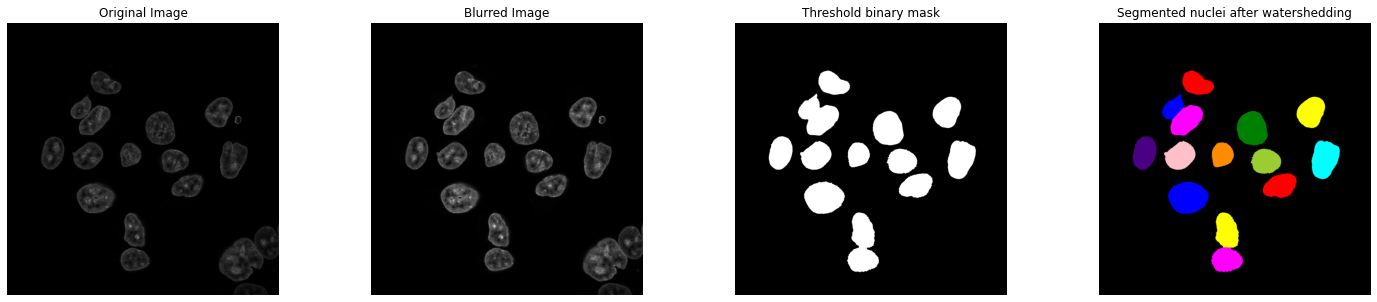

well1_2045_plus_aux_pos17-28 #12.tif


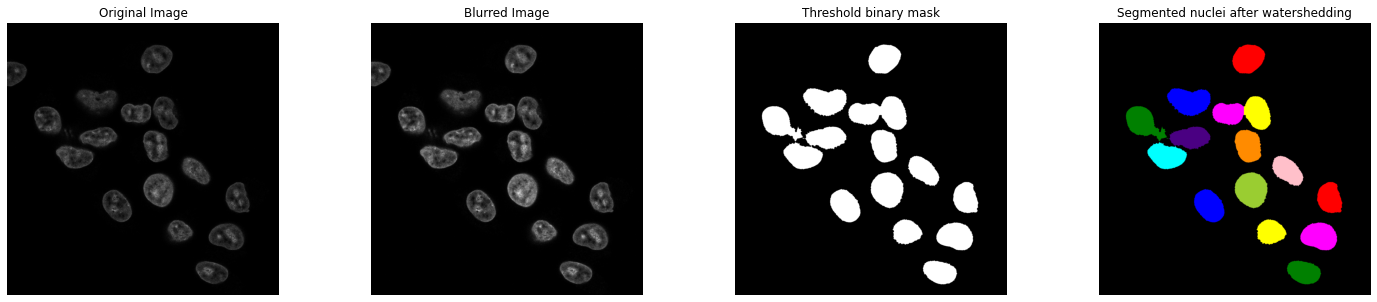

well2_2045_plus_aux_po1-19 #01.tif


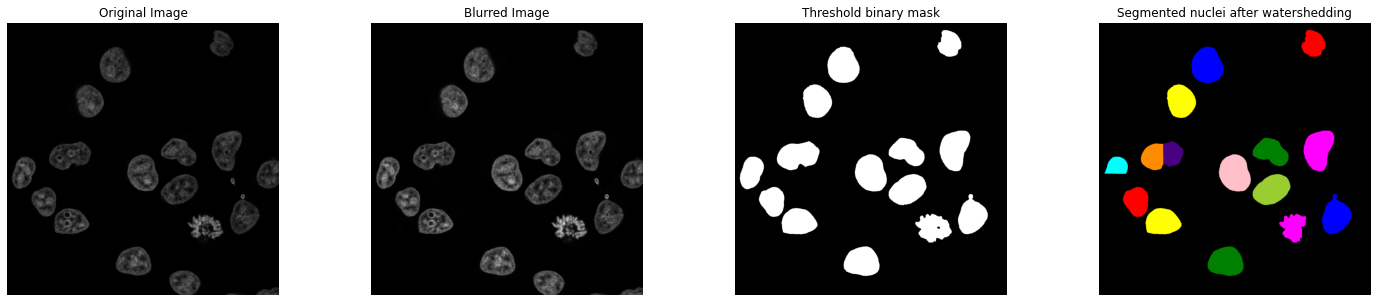

well2_2045_plus_aux_po1-19 #04.tif


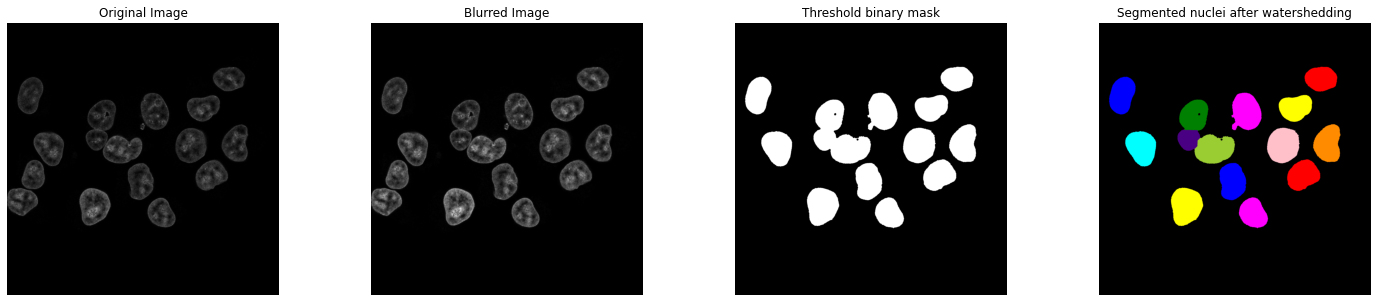

well2_2045_plus_aux_po1-19 #02.tif


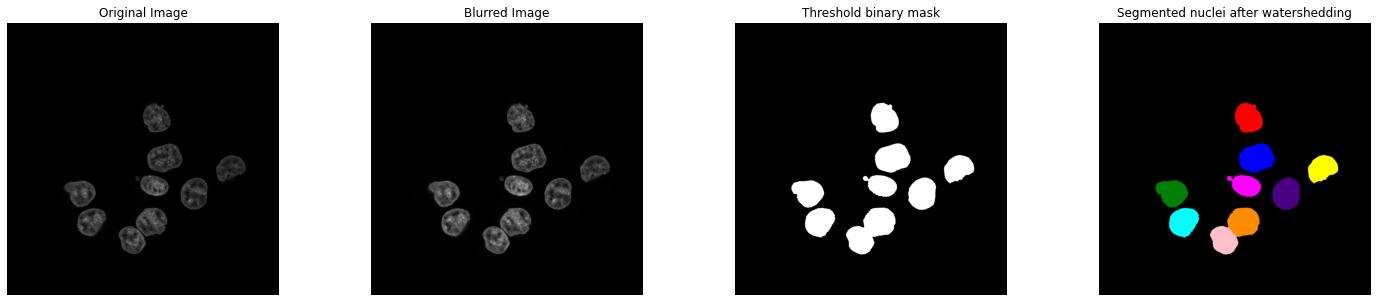

well2_2045_plus_aux_po1-19 #03.tif


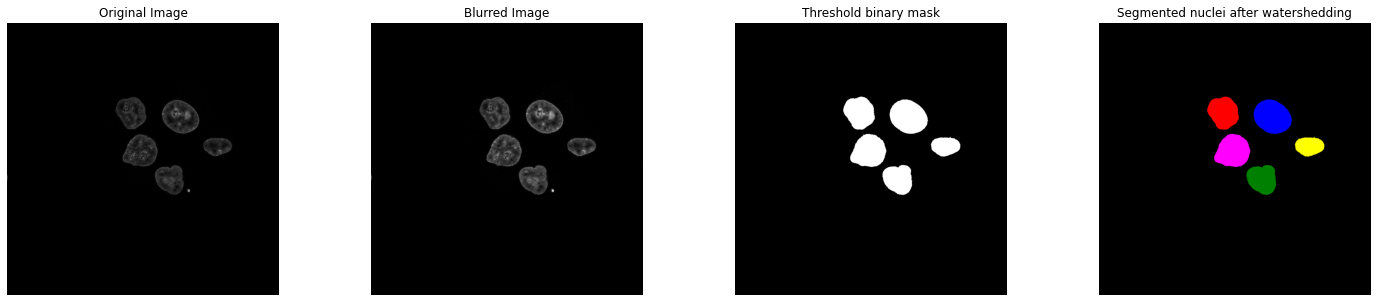

well2_2045_plus_aux_po1-19 #05.tif


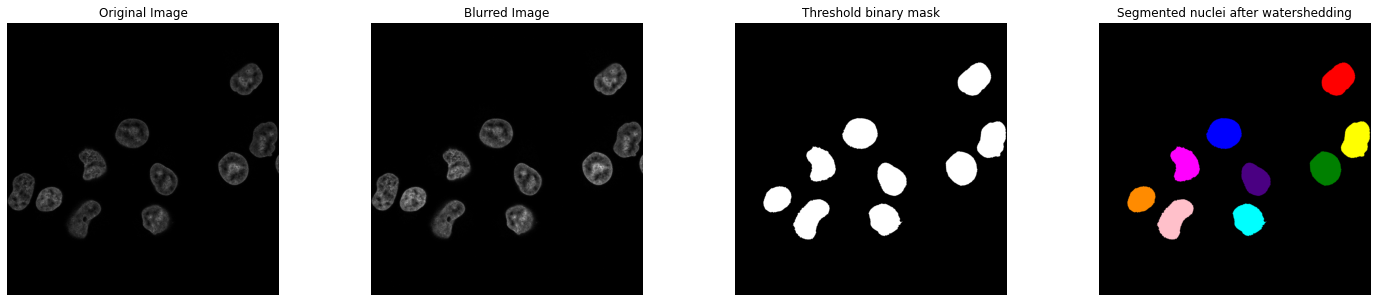

well2_2045_plus_aux_po1-19 #08.tif


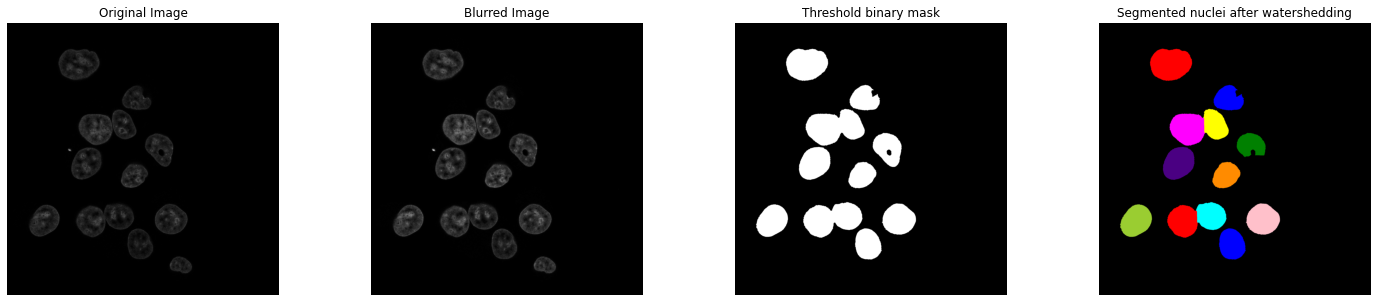

well2_2045_plus_aux_po1-19 #09.tif


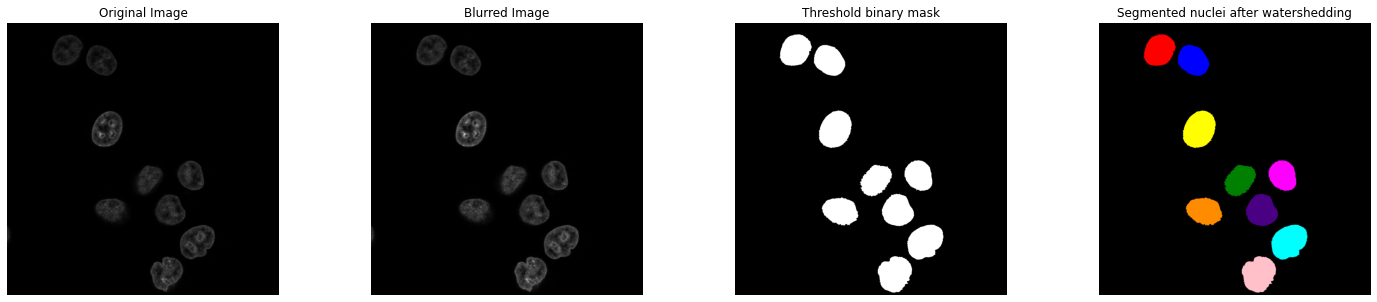

well2_2045_plus_aux_po1-19 #11.tif


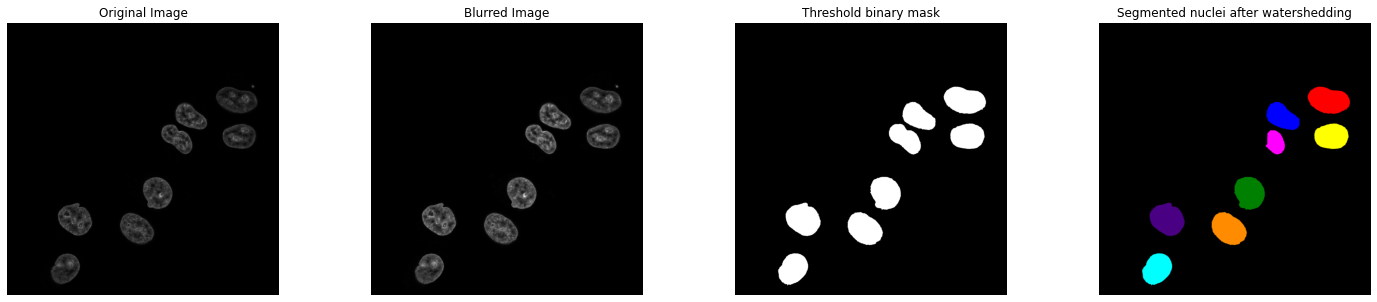

well2_2045_plus_aux_po1-19 #12.tif


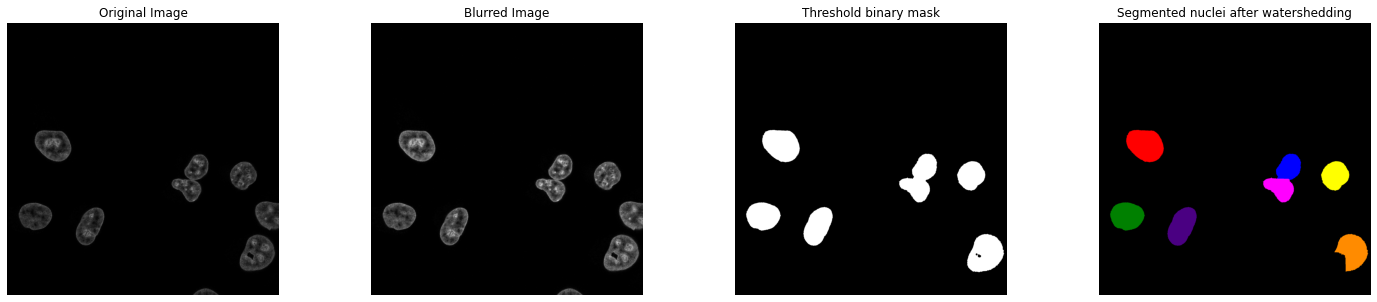

well2_2045_plus_aux_po1-19 #13.tif


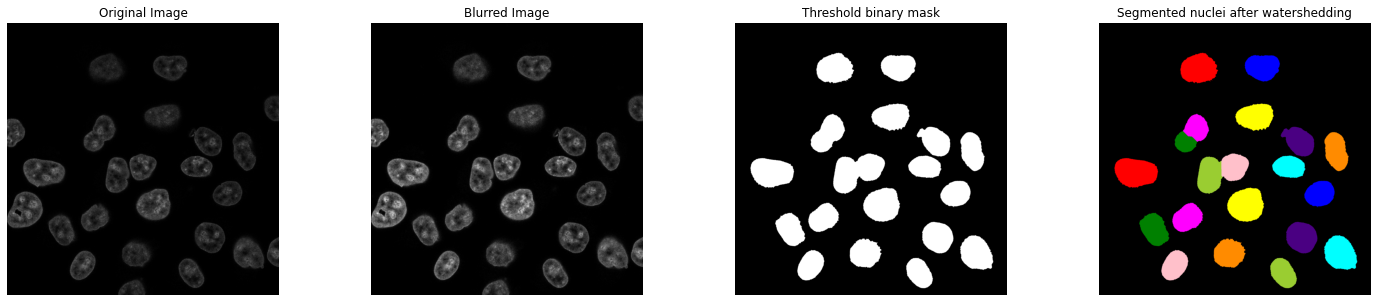

well2_2045_plus_aux_po1-19 #14.tif


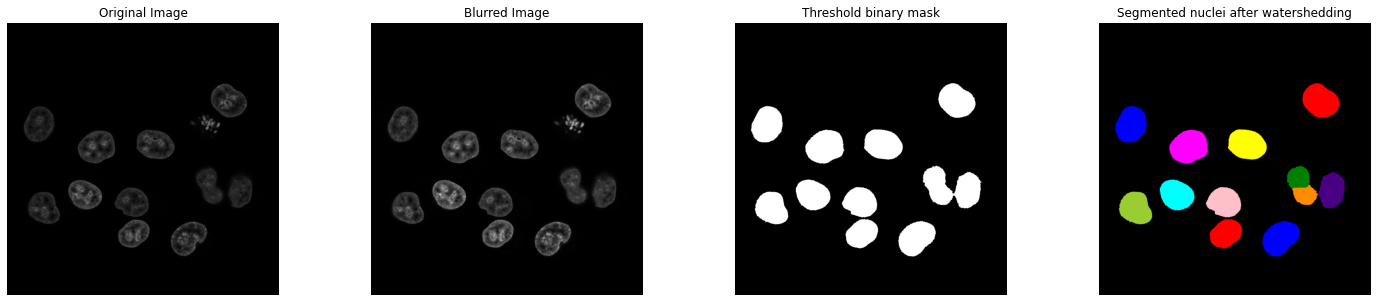

well2_2045_plus_aux_po1-19 #15.tif


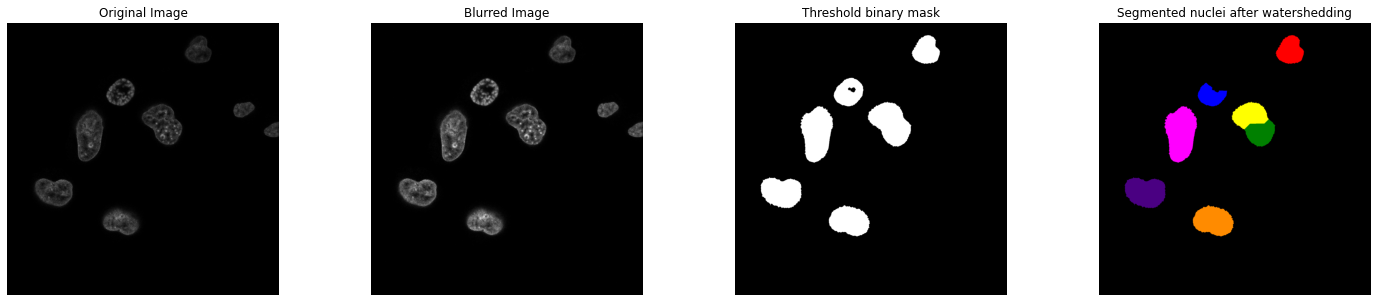

well2_2045_plus_aux_po1-19 #16.tif


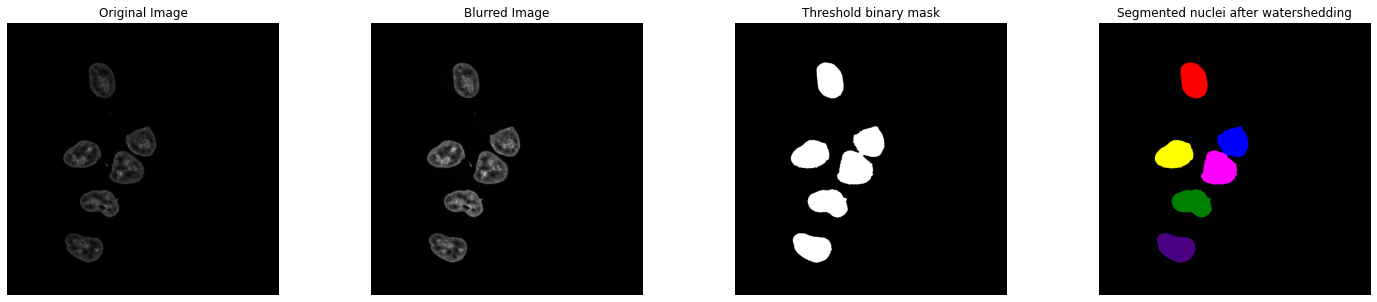

well2_2045_plus_aux_po1-19 #17.tif


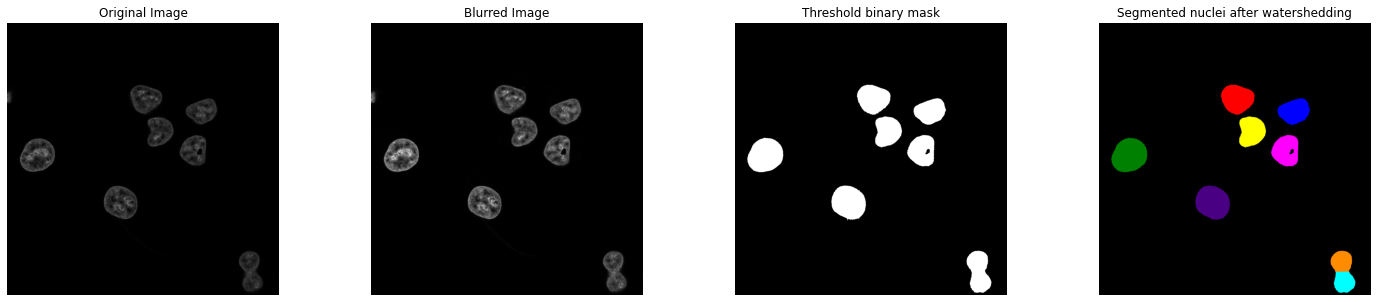

well2_2045_plus_aux_po1-19 #18.tif


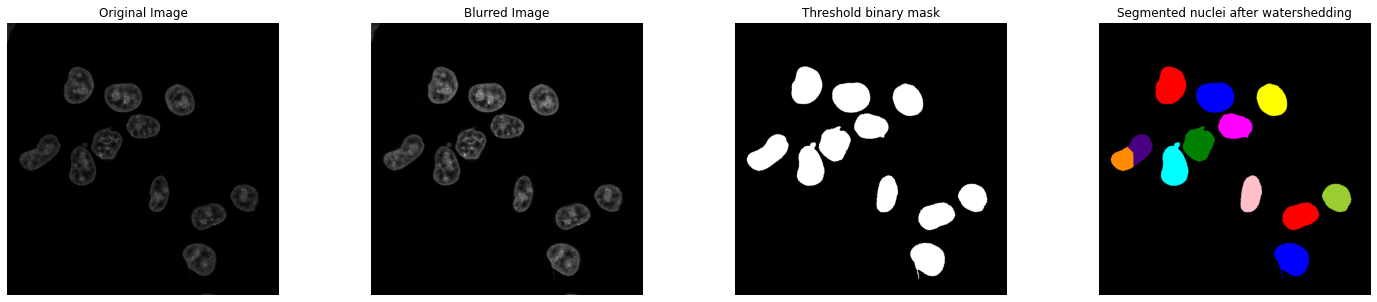

well2_2045_plus_aux_po1-19 #19.tif


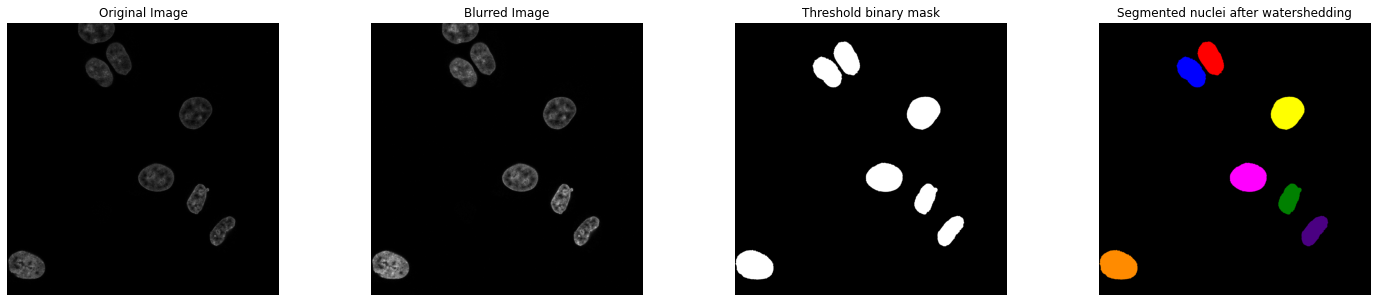

well2_2045_plus_aux_ps20-32 #01.tif


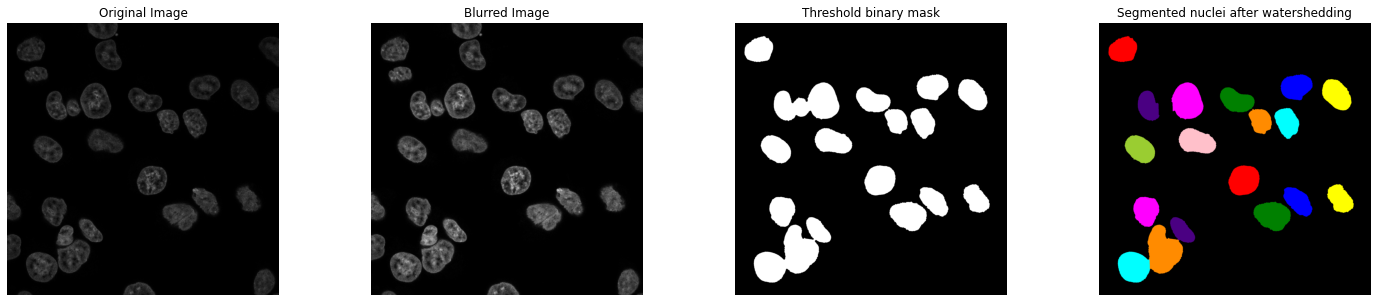

well2_2045_plus_aux_ps20-32 #02.tif


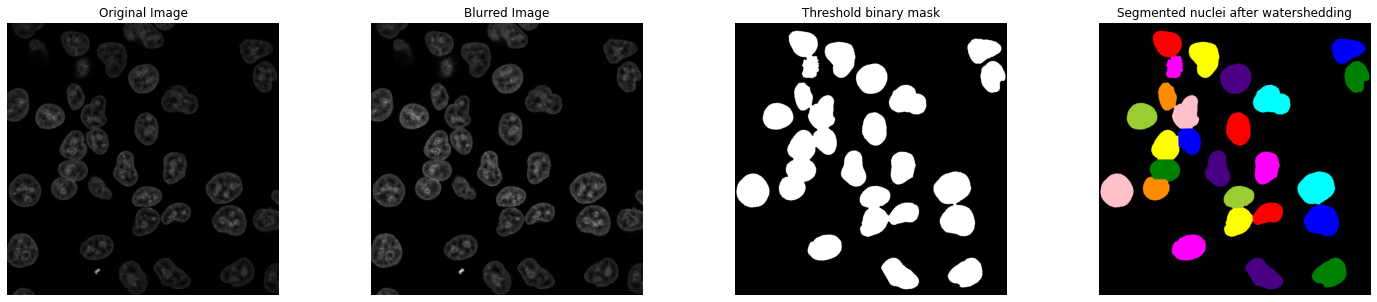

well2_2045_plus_aux_ps20-32 #03.tif


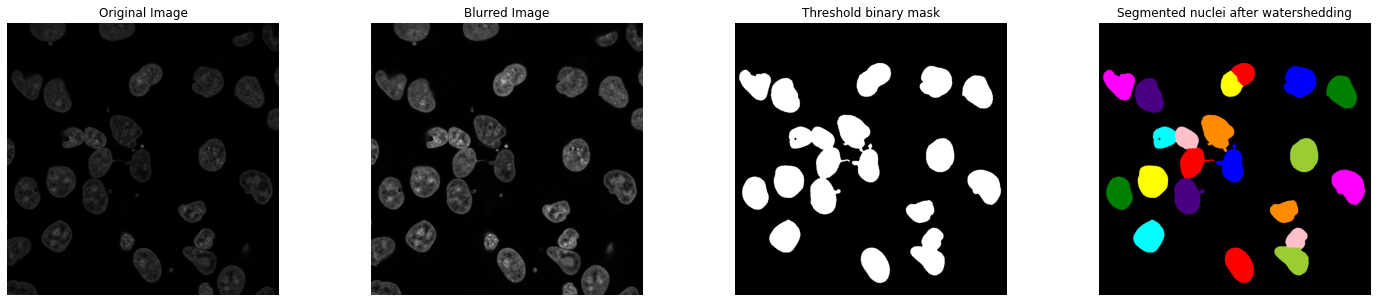

well2_2045_plus_aux_ps20-32 #04.tif


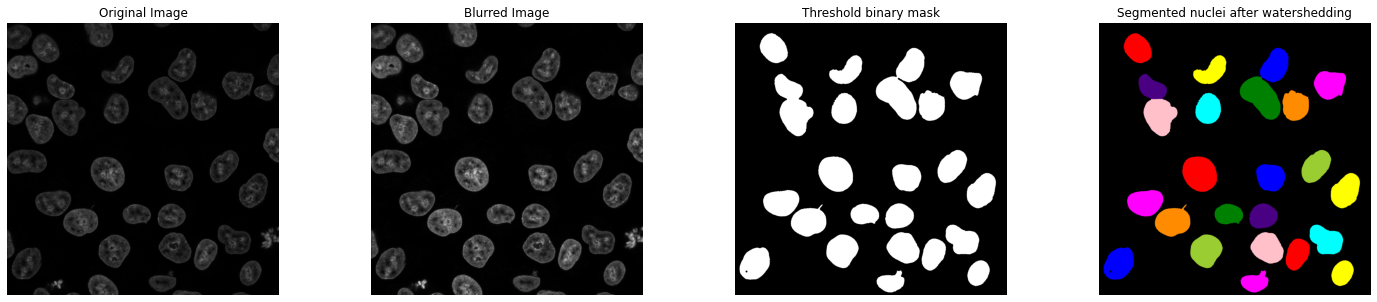

well2_2045_plus_aux_ps20-32 #05.tif


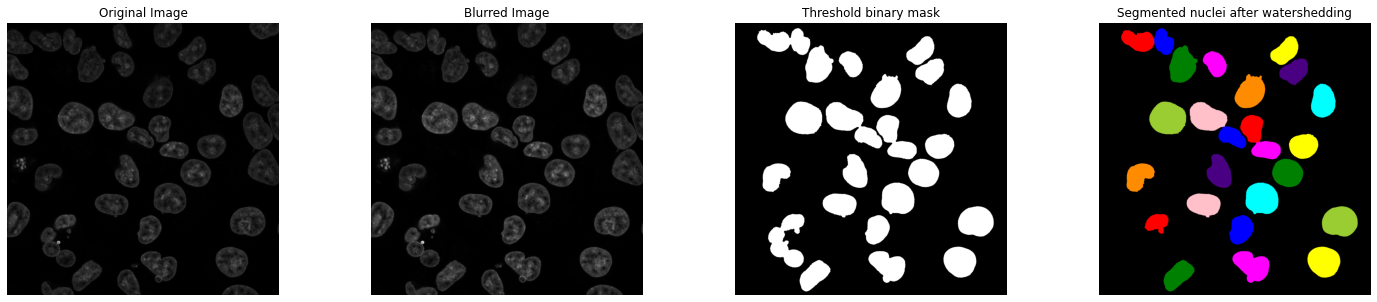

well2_2045_plus_aux_ps20-32 #06.tif


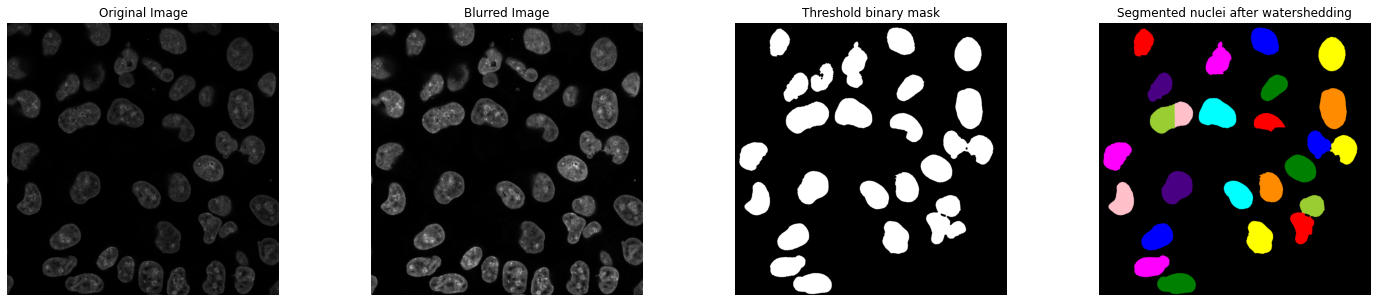

well2_2045_plus_aux_ps20-32 #07.tif


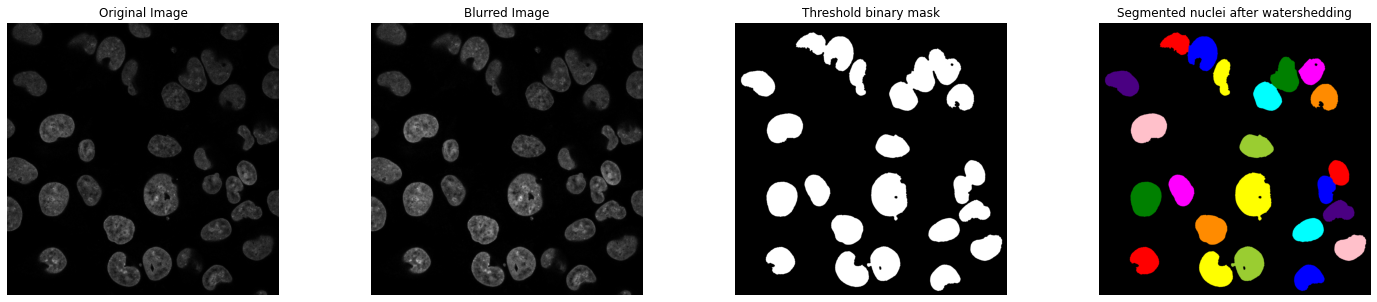

well2_2045_plus_aux_ps20-32 #08.tif


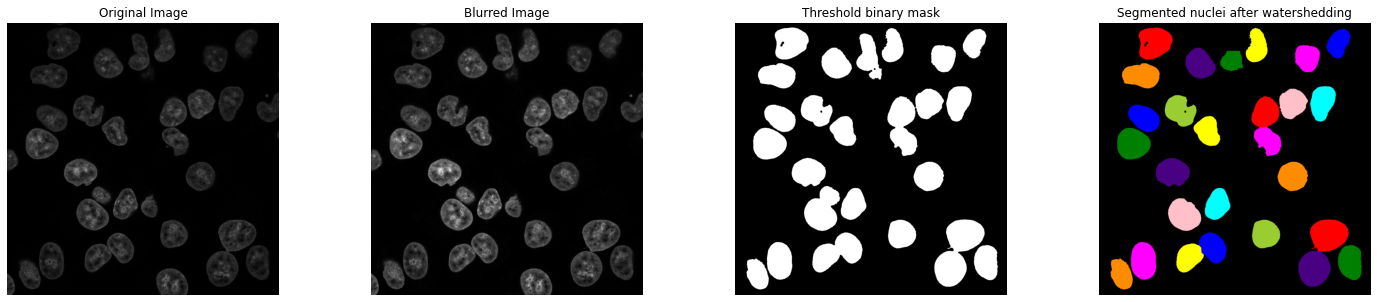

well2_2045_plus_aux_ps20-32 #09.tif


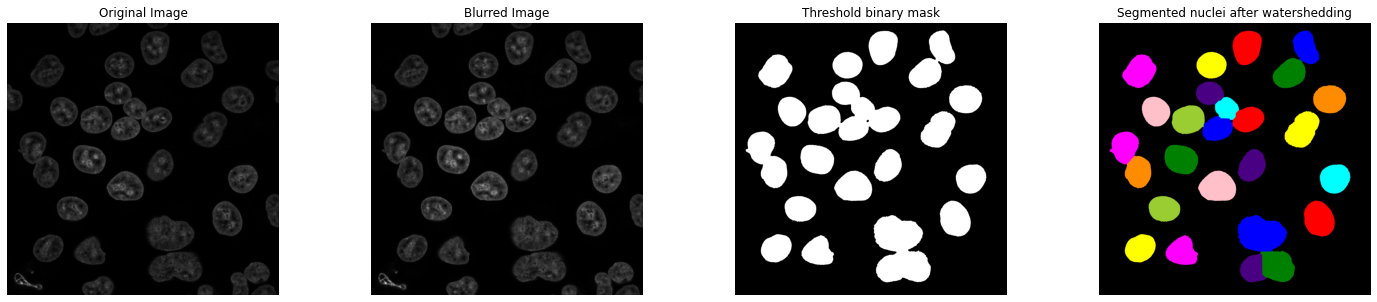

well2_2045_plus_aux_ps20-32 #10.tif


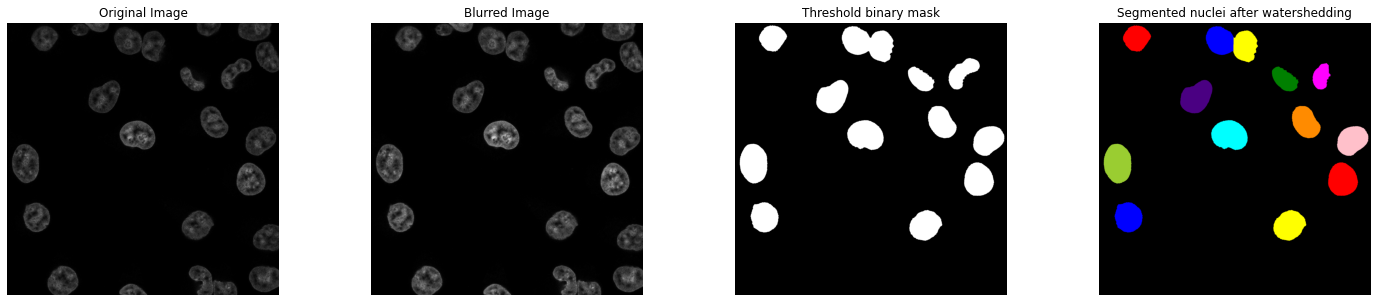

well2_2045_plus_aux_ps20-32 #11.tif


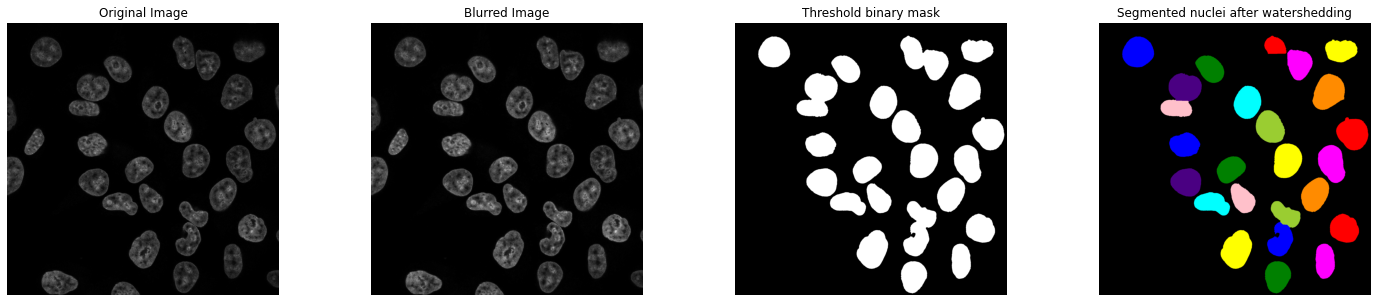

well2_2045_plus_aux_ps20-32 #12.tif


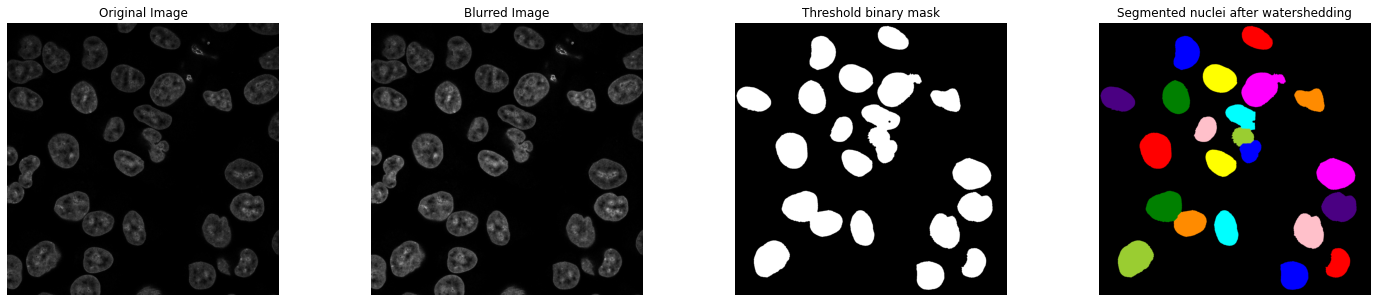

well2_2045_plus_aux_ps20-32 #13.tif


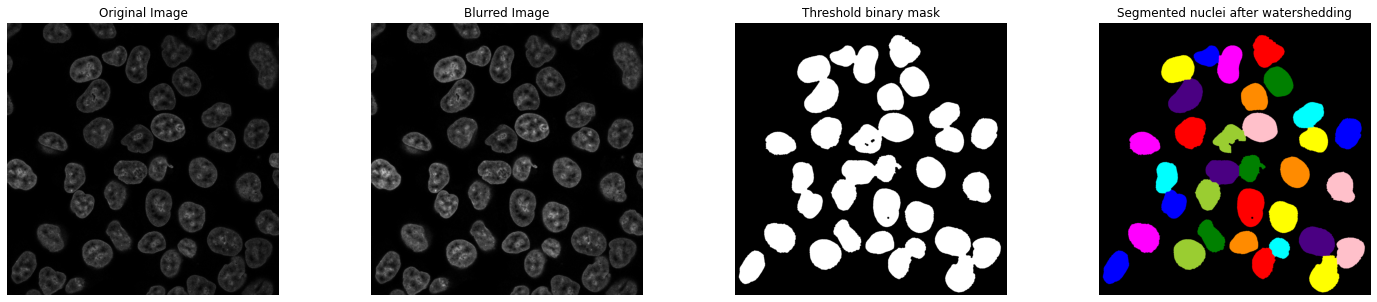

well1_2045_plus_aux_po1-16 #01.tif


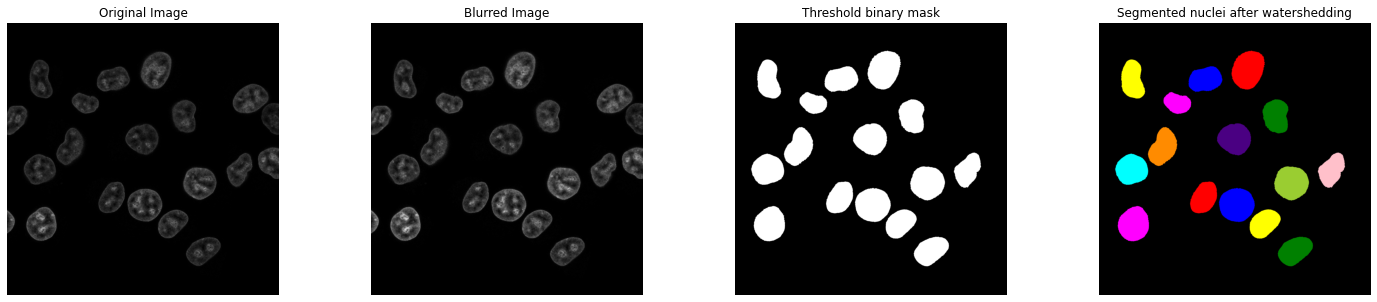

In [11]:
inpath = ("/groups/gerlich/experiments/Experiments_005600/005606/images/tifs/attempt3_220915/2045_plus_aux/")
os.chdir(inpath)
images = glob('*.tif', recursive=True)
result = threshold_field(images)

#data = io.imread("/groups/gerlich/experiments/Experiments_005200/005223/Images/Projections/short_g2_scc1_smc4/2108_zoom5_0_control_short_G2_cycB1_SMC4_Scc1_EGFP_Hoechst-02-64.czi #1.tif_registered.tif")

In [12]:
result

image_name  nuclear_area_microns  mean_hoechst  \
0   well1_2045_plus_aux_po1-16 #01.tif            185.199339     16.105310   
1   well1_2045_plus_aux_po1-16 #01.tif            119.984024     20.467843   
2   well1_2045_plus_aux_po1-16 #01.tif            134.774664     17.496969   
3   well1_2045_plus_aux_po1-16 #01.tif            190.146158     22.081375   
4   well1_2045_plus_aux_po1-16 #01.tif            179.878893     20.101723   
..                                 ...                   ...           ...   
10  well1_2045_plus_aux_po1-16 #01.tif            158.323117     19.456153   
11  well1_2045_plus_aux_po1-16 #01.tif            232.385915     25.413587   
12  well1_2045_plus_aux_po1-16 #01.tif            206.720244     29.602371   
13  well1_2045_plus_aux_po1-16 #01.tif            158.029197     21.917817   
14  well1_2045_plus_aux_po1-16 #01.tif            174.917129     19.095950   

    mean_nipbl  total_hoechst  total_nuclear_nipbl  std_hoechst  std_nipbl  \
0     7.025904    2982.692745          1301.192742     8.591453   4.152254   
1     7.265559    2455.814176           871.751064    10.867092   4.557679   
2     7.344755    2358.148126           989.886881     9.600929   4.703926   
3     7.158427    4198.688610          1361.147391    11.522791   4.360314   
4     7.224050    3615.875616          1299.454132    10.750260   4.507498   
..         ...            ...                  ...          ...        ...   
10    7.138227    3080.358794          1130.146386    11.711355   4.280180   
11    7.231628    5905.759632          1680.528573    15.103023   4.486384   
12    7.301909    6119.409408          1509.452328    17.627193   4.664458   
13    7.179907    3463.655070          1134.634890    12.398385   4.454345   
14    7.196372    3340.208771          1258.768663    11.446455   4.509683   

    coeff_variance_hoechst  coeff_variance_nipbl        condition  
0                 0.533455              0.590992  2045_plus_auxin  
1                 0.530935              0.627299  2045_plus_auxin  
2                 0.548720              0.640447  2045_plus_auxin  
3                 0.521833              0.609116  2045_plus_auxin  
4                 0.534793              0.623957  2045_plus_auxin  
..                     ...                   ...              ...  
10                0.601936              0.599614  2045_plus_auxin  
11                0.594289              0.620384  2045_plus_auxin  
12                0.595466              0.638800  2045_plus_auxin  
13                0.565676              0.620390  2045_plus_auxin  
14                0.599418              0.626661  2045_plus_auxin  

[744 rows x 11 columns]

In [ ]:
# Testing thresholding on single image using cellpose and napari

# To do, use command line and cell pose to apply thresholding to a folder of cells

In [ ]:
data = io.imread("/groups/gerlich/experiments/Experiments_005600/005606/images/tifs/2096_minus_dtag/2096_minus_dtag_stain_hoechst_scc1_pos1-6 #06.tif")
#mask = io.imread("/groups/gerlich/experiments/Experiments_005000/005003/TIFs_registered_background_subtracted_testing/WT_fully_noR/Rep1/1/slices/20/Mask.tif")
print("shape: {}".format(data.shape))
print("dtype: {}".format(data.dtype))
print("range: ({}, {})".format(data.min(), data.max()))

#print("m shape: {}".format(mask.shape))
#print("m dtype: {}".format(mask.dtype))
#print("m range: ({}, {})".format(mask.min(), mask.max()))

In [ ]:
hoechst = data[0,:,:]
scc1 = data[1,:,:]
#wapl_ha = data[:,:,2]
display_slice(hoechst)
